# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head(100)

critic   fresh    imdb              publication                                              quote review_date   rtid                   title
1           Derek Adams   fresh  114709                 Time Out  So ingenious in concept, design and execution ...  2009-10-04   9559               Toy story
2       Richard Corliss   fresh  114709            TIME Magazine                  The year's most inventive comedy.  2008-08-31   9559               Toy story
3           David Ansen   fresh  114709                 Newsweek  A winning animated feature that has something ...  2008-08-18   9559               Toy story
4         Leonard Klady   fresh  114709                  Variety  The film sports a provocative and appealing st...  2008-06-09   9559               Toy story
5    Jonathan Rosenbaum   fresh  114709           Chicago Reader  An entertaining computer-generated, hyperreali...  2008-03-10   9559               Toy story
6         Michael Booth   fresh  114709              Denver Post  As Lion King did before it, Toy Story revived ...  2007-05-03   9559               Toy story
7          Geoff Andrew   fresh  114709                 Time Out  The film will probably be more fully appreciat...  2006-06-24   9559               Toy story
8          Janet Maslin   fresh  114709           New York Times  Children will enjoy a new take on the irresist...  2003-05-20   9559               Toy story
9         Kenneth Turan   fresh  114709        Los Angeles Times  Although its computer-generated imagery is imp...  2001-02-13   9559               Toy story
10     Susan Wloszczyna   fresh  114709                USA Today  How perfect that two of the most popular funny...  2000-01-01   9559               Toy story
11          Roger Ebert   fresh  114709        Chicago Sun-Times  The result is a visionary roller-coaster ride ...  2000-01-01   9559               Toy story
12           John Hartl   fresh  114709                 Film.com  Disney's witty, wondrously imaginative, all-co...  2000-01-01   9559               Toy story
13          Susan Stark   fresh  114709             Detroit News  Disney's first computer-made animated feature ...  2000-01-01   9559               Toy story
14          Peter Stack   fresh  114709  San Francisco Chronicle  The script, by Lasseter, Pete Docter, Andrew S...  2000-01-01   9559               Toy story
15   James Berardinelli   fresh  114709                ReelViews  The one big negative about Toy Story involves ...  2000-01-01   9559               Toy story
16           Sean Means   fresh  114709                 Film.com         Technically, Toy Story is nearly flawless.  2000-01-01   9559               Toy story
17         Rita Kempley   fresh  114709          Washington Post  It's a nice change of pace to see the studio d...  2000-01-01   9559               Toy story
18                  NaN   fresh  114709     Entertainment Weekly  I can hardly imagine having more fun at the mo...  1995-11-22   9559               Toy story
19          Roger Moore   fresh  114709         Orlando Sentinel  The great voice acting, the visual puns, all a...  1995-11-22   9559               Toy story
30          Roger Ebert  rotten  113497        Chicago Sun-Times  A gloomy special-effects extravaganza filled w...  2000-01-01  12436                 Jumanji
32                  NaN   fresh  113497                USA Today  A calculated but very entertaining special eff...  2000-01-01  12436                 Jumanji
36     Richard Schickel   fresh  107050            TIME Magazine  Walter Matthau and Jack Lemmon are awfully goo...  2008-08-24  10498          Grumpy Old Men
37          Derek Adams  rotten  107050                 Time Out                             Mediocre, regrettably.  2006-06-24  10498          Grumpy Old Men
38          Caryn James   fresh  107050           New York Times  Just don't expect their bickering to be on the...  2003-05-20  10498          Grumpy Old Men
39   James Berardinelli   fresh  107050   

### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


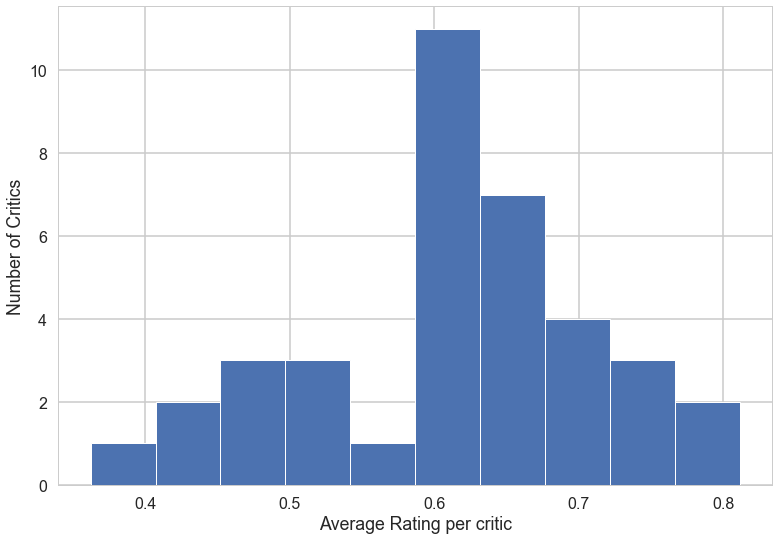

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

### Answer

The distribution looks to be a normal distribution with a negative skew - in other words the distribution is weighted to results > 0.5. This might be because there's a binomial distribution "hidden" in here, as results that are > 0.5 are additionally classifed as "fresh" and those < 0.5 are classified as "rotten". From the data it would seem that critics are more inclined to give films a "fresh" rating than a "rotten" one, even if that means giving a score on the 0.6 borderline. But then, if the critic decides that a film is indeed "rotten", they don't go in much for borderline scores (of 0.4) but prefer lower scores. It seems that critics generally try to be nice, and would rather be positive about a film, but that if they decide they can't be positive, then they're better off being really negative than mildly negative. If you're going to be brutal, might as not mince words...

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [6]:
def make_xy(critics, vectorizer=None):
    #Your code here 
    print("Original text is\n{}".format('\n'.join(critics.quote)))
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    
    print("")
    print("Transformed text vector is \n{}".format(X))

    # `get_feature_names` tracks which word is associated with each column of the transformed x
    print("")
    print("Words for each feature:")
    print(vectorizer.get_feature_names())
    
    return X, y

X, y = make_xy(critics)




Original text is
So ingenious in concept, design and execution that you could watch it on a postage stamp-sized screen and still be engulfed by its charm.
The year's most inventive comedy.
A winning animated feature that has something for everyone on the age spectrum.
The film sports a provocative and appealing story that's every bit the equal of this technical achievement.
An entertaining computer-generated, hyperrealist animation feature (1995) that's also in effect a toy catalog.
As Lion King did before it, Toy Story revived the art of American children's animation, and ushered in a set of smart movies that entertained children and their parents. It's a landmark movie, and doesn't get old with frequent repetition.
The film will probably be more fully appreciated by adults, who'll love the snappy, knowing verbal gags, the vivid, deftly defined characters, and the overall conceptual sophistication.
Children will enjoy a new take on the irresistible idea of toys coming to life. Adults 


Transformed text vector is 
  (1028, 0)	1
  (3215, 0)	1
  (4740, 0)	1
  (4741, 0)	1
  (8722, 0)	2
  (8820, 0)	1
  (12118, 0)	1
  (4031, 1)	1
  (74, 2)	1
  (76, 2)	1
  (3653, 2)	1
  (4031, 2)	1
  (8023, 2)	1
  (10704, 2)	1
  (13425, 2)	1
  (13435, 2)	1
  (13668, 2)	1
  (13693, 2)	1
  (8647, 3)	1
  (369, 4)	1
  (24, 5)	1
  (65, 5)	1
  (472, 5)	1
  (625, 5)	1
  (731, 5)	1
  :	:
  (14548, 22402)	1
  (14551, 22402)	1
  (958, 22403)	1
  (10209, 22403)	1
  (6804, 22404)	1
  (8594, 22405)	1
  (14697, 22406)	1
  (6465, 22407)	1
  (4134, 22408)	1
  (8145, 22408)	1
  (4471, 22409)	1
  (4477, 22409)	1
  (4478, 22409)	1
  (4476, 22410)	1
  (8847, 22411)	1
  (1076, 22412)	1
  (3126, 22412)	1
  (3128, 22412)	1
  (9252, 22412)	1
  (2774, 22413)	1
  (3360, 22414)	1
  (5930, 22414)	1
  (10457, 22414)	1
  (4473, 22415)	1
  (8518, 22416)	1

Words for each feature:
['000', '0014', '007', '044', '07', '10', '100', '101', '102', '104', '105', '108', '10th', '11', '110', '112', '1138', '114', '118', '11th', 

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [6]:
#your turn

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train, y_train)

In [8]:
from sklearn import metrics

predicted = clf.predict(X_test)
print("\nMean prediction accuracy is: ", np.mean(predicted == y_test))
print("\n\nClassification report:\n", metrics.classification_report(y_test, predicted))
print("\n\nConfusion matrix:\n", metrics.confusion_matrix(y_test, predicted))


Mean prediction accuracy is:  0.759518072289


Classification report:
              precision    recall  f1-score   support

          0       0.75      0.59      0.66      2477
          1       0.76      0.87      0.81      3748

avg / total       0.76      0.76      0.75      6225



Confusion matrix:
 [[1452 1025]
 [ 472 3276]]


### Comment

It's not a brilliant classifier. If we're looking at predicting whether a review will be classified as "fresh" or "rotten" then we're only getting 75-76% accuracy, which is better than chance (50%) but not really stellar in terms of operational performance. It seems likely that many reviews will contain both positive and negative comments, and that there will be a lot of cross-over in terms of word features between both "fresh" and "rotten" reviews, making it difficult for the classifier to distinguish between them. In addition, use of irony and sarcasm by critics - using words in a sense opposite to their general dictionary meaning - would be likely to confuse the classifier. Finally, we're using full words here, instead of filtering for verb declentions, plurals, possessives, and frequently occuring words that add grammatical structure but not much semantic meaning, and this is likely to be further affecting performance.

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [7]:
# Your turn.

import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet

wnl = WordNetLemmatizer()

def map_wordnet_pos(treebank_tag):
    """Map the NLTK pos tags onto the pre-trained Treebank tag set"""
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    elif treebank_tag.startswith("S"):
        return wordnet.ADJ_SAT
    else:
        return wordnet.NOUN

def clean_text(document):
    """Clean and lemmatize the submitted content"""
    text = [] # list to hold all lemmatised words in this article
    stop_words = set(stopwords.words("english"))  # load stopwords
    # Tokenize words
    words = word_tokenize(document)
    # Remove punctuation
    words = [x for x in words if x not in string.punctuation]
    # Remove single character words
    words = [x for x in words if len(x) > 1]
    # Remove irrelevant words and characters
    stoplist = set("for a of the and to in 's".split()) # Tried with these too; no difference: </p> <p> \\\" \\\n
    words = [x for x in words if x not in stoplist]
    # Remove stopwords
    words = [x for x in words if x not in stop_words]
    # Derive part-of-speech (POS) tags
    words = nltk.pos_tag(words)
    # Lemmatize the cleaned word set
    for word, pos in words:
        tag = map_wordnet_pos(pos) # Call function to map POS tags from Treebank to NLTK
        lemma = wnl.lemmatize(word, tag)
        text.append(lemma) # Add the lemmatized word to the list for this article
    return text

# Isolate the reviews in the dataframe
df_words = critics["quote"]

# Put the reviews into a list 
documents = [document for document in df_words]
texts = []

# Remove punctuation and lemmatize the reviews
for document in documents:
    text = clean_text(document)
    # Add the article to the list of all articles
    texts.append(text)


In [48]:
texts

[['So',
  'ingenious',
  'concept',
  'design',
  'execution',
  'could',
  'watch',
  'postage',
  'stamp-sized',
  'screen',
  'still',
  'engulf',
  'charm'],
 ['The', 'year', 'inventive', 'comedy'],
 ['win', 'animated', 'feature', 'something', 'everyone', 'age', 'spectrum'],
 ['The',
  'film',
  'sport',
  'provocative',
  'appeal',
  'story',
  'every',
  'bit',
  'equal',
  'technical',
  'achievement'],
 ['An',
  'entertaining',
  'computer-generated',
  'hyperrealist',
  'animation',
  'feature',
  '1995',
  'also',
  'effect',
  'toy',
  'catalog'],
 ['As',
  'Lion',
  'King',
  'Toy',
  'Story',
  'revive',
  'art',
  'American',
  'child',
  'animation',
  'usher',
  'set',
  'smart',
  'movie',
  'entertain',
  'child',
  'parent',
  'It',
  'landmark',
  'movie',
  "n't",
  'get',
  'old',
  'frequent',
  'repetition'],
 ['The',
  'film',
  'probably',
  'fully',
  'appreciate',
  'adult',
  "'ll",
  'love',
  'snappy',
  'know',
  'verbal',
  'gag',
  'vivid',
  'deftly',

In [105]:
len(texts)

15561

In [50]:
# Create a dictionary and tally the occurrence of each words
occurrences = {}
for text in texts:
    found_words = set([])
    for word in text:
        if word in found_words:
            continue
        occurrences[word] = 1 + occurrences.get(word,0)
        found_words.add(word)

In [51]:
occurrences


{'So': 45,
 'ingenious': 21,
 'concept': 30,
 'design': 74,
 'execution': 17,
 'could': 253,
 'watch': 225,
 'postage': 2,
 'stamp-sized': 1,
 'screen': 256,
 'still': 268,
 'engulf': 2,
 'charm': 163,
 'The': 2785,
 'year': 286,
 'inventive': 45,
 'comedy': 586,
 'win': 44,
 'animated': 27,
 'feature': 195,
 'something': 259,
 'everyone': 55,
 'age': 98,
 'spectrum': 3,
 'film': 2464,
 'sport': 31,
 'provocative': 40,
 'appeal': 115,
 'story': 657,
 'every': 199,
 'bit': 116,
 'equal': 26,
 'technical': 41,
 'achievement': 55,
 'An': 336,
 'entertaining': 91,
 'computer-generated': 18,
 'hyperrealist': 1,
 'animation': 85,
 '1995': 9,
 'also': 237,
 'effect': 225,
 'toy': 16,
 'catalog': 1,
 'As': 286,
 'Lion': 6,
 'King': 52,
 'Toy': 9,
 'Story': 30,
 'revive': 4,
 'art': 113,
 'American': 225,
 'child': 106,
 'usher': 1,
 'set': 204,
 'smart': 102,
 'movie': 2425,
 'entertain': 181,
 'parent': 37,
 'It': 1393,
 'landmark': 10,
 "n't": 1269,
 'get': 472,
 'old': 166,
 'frequent': 7,


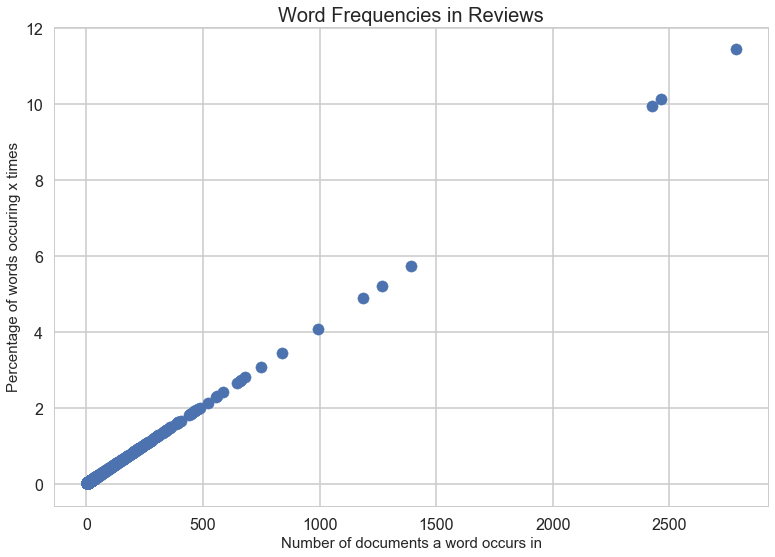

In [56]:
# Plot the Construct the cumulative distribution of document frequencies (df). 
# The  x-axis is a document count  xi  and the  y-axis is the percentage 
# of words that appear less than  xi  times. For example, at  x=5 , plot 
# a point representing the percentage or number of words that appear in 5 or fewer documents.

import matplotlib.pyplot as plt

x_values = []
y_values = []

for word, value in occurrences.items():
    x_values.append(value)
    y_values.append((value/len(occurrences))*100)

plt.title("Word Frequencies in Reviews", fontsize = 20)
plt.ylabel("Percentage of words occuring x times", fontsize = 15)
plt.xlabel("Number of documents a word occurs in", fontsize = 15)    
plt.scatter(x_values, y_values)
plt.show()


### My answer:

The original question was: "Look for the point at which the curve begins climbing steeply. This may be a good value for min_df. If we were interested in also picking max_df, we would likely pick the value where the curve starts to plateau. What value did you choose?"

Because I removed punctuation and lemmatized the words, my spread of results is not as broad as it otherwise might have been. Clearly, though, we can see that any word that appears in more than 2500 documents is likely to be a stopword or equivalent, and can probably be safely ignored - so that could be our figure for max_df. Min_df is harder to see at the scale of this chart, but there's clearly a lot of bunching below 500 documents. I'd probably set min_df quite low, therefore. There are around 25000 documents in this sample (the number of reviews), and 1% of words appears in around 1% of them (i.e. 1% on the y axis intersects around the 250 mark on the x axis). It would probably be safe to ignore anything below this as too idiosyncratic to help formulate a general rule for review sentiment analysis, meaning that we could set min_df at 250. We can see this a bit more clearly if we use a log base 10 graph, as shown below:

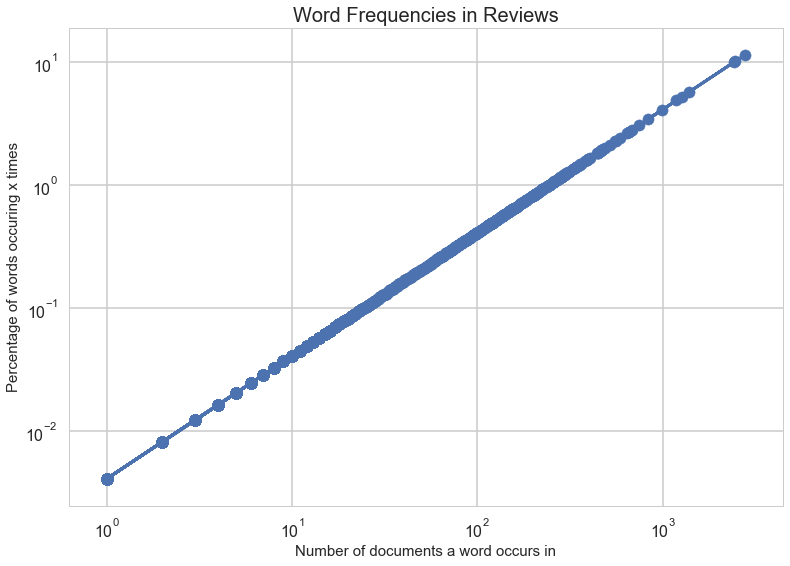

In [57]:
plt.title("Word Frequencies in Reviews", fontsize = 20)
plt.ylabel("Percentage of words occuring x times", fontsize = 15)
plt.xlabel("Number of documents a word occurs in", fontsize = 15)    
plt.loglog(x_values, y_values, basex=10)
plt.scatter(x_values, y_values)
plt.show()

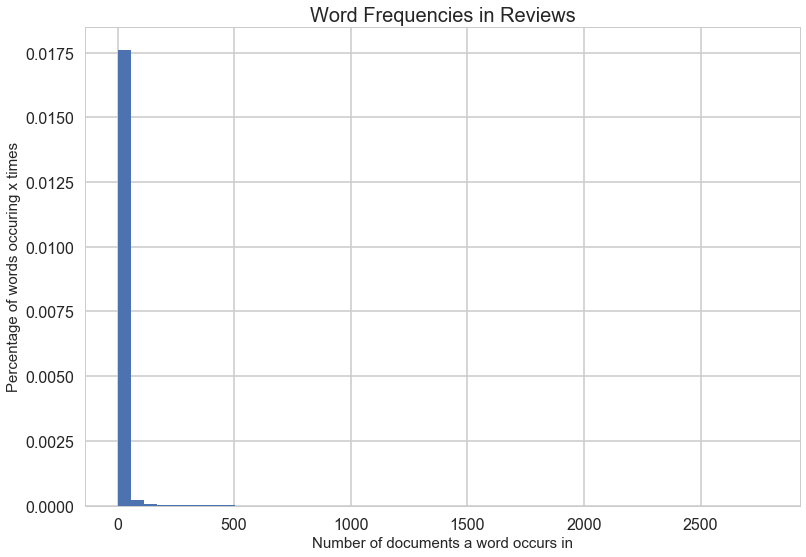

In [109]:

import matplotlib.pyplot as plt

x_values = []
y_values = []

for word, value in occurrences.items():
    x_values.append(value)
    y_values.append((value/len(occurrences))*100)

plt.title("Word Frequencies in Reviews", fontsize = 20)
plt.ylabel("Percentage of words occuring x times", fontsize = 15)
plt.xlabel("Number of documents a word occurs in", fontsize = 15)    
plt.hist(x_values, bins=50, normed=True)
plt.show()

In [111]:
x_values.sort()
x_values

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


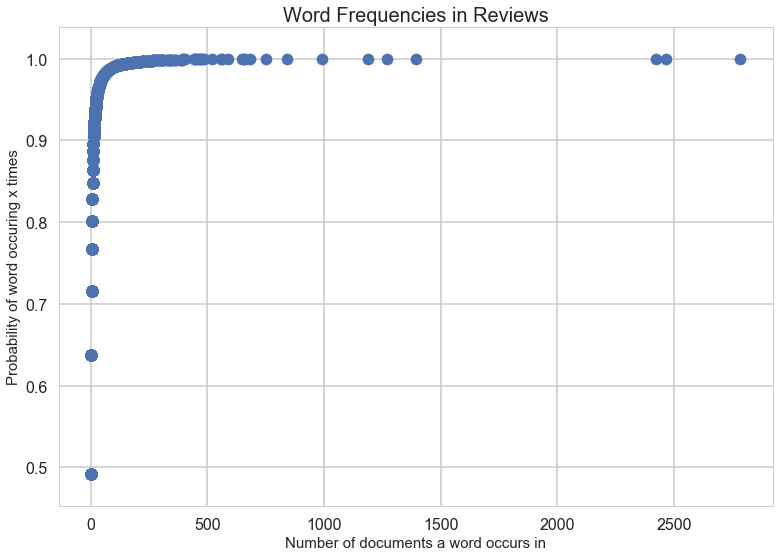

In [113]:
# Plot the Construct the cumulative distribution of document frequencies (df). 
# The  x-axis is a document count  xi  and the  y-axis is the percentage 
# of words that appear less than  xi  times. For example, at  x=5 , plot 
# a point representing the percentage or number of words that appear in 5 or fewer documents.

import matplotlib.pyplot as plt

def Cdf(t, x):
    count = 0.0
    for word, value in t.items():
        if value <= x:
            count += 1.0

    prob = count / len(occurrences)
    return prob

x_values = []
y_values = []

for word, value in occurrences.items():
    x_values.append(value)
    y_values.append(Cdf(occurrences, value))

plt.title("Word Frequencies in Reviews", fontsize = 20)
plt.ylabel("Probability of word occuring x times", fontsize = 15)
plt.xlabel("Number of documents a word occurs in", fontsize = 15)    
plt.scatter(x_values, y_values)
plt.show()

In [116]:
texts = []
for document in documents:
    # text = clean_text(document)
    # Add the article to the list of all articles
    texts.append(document)

In [117]:
texts

['So ingenious in concept, design and execution that you could watch it on a postage stamp-sized screen and still be engulfed by its charm.',
 "The year's most inventive comedy.",
 'A winning animated feature that has something for everyone on the age spectrum.',
 "The film sports a provocative and appealing story that's every bit the equal of this technical achievement.",
 "An entertaining computer-generated, hyperrealist animation feature (1995) that's also in effect a toy catalog.",
 "As Lion King did before it, Toy Story revived the art of American children's animation, and ushered in a set of smart movies that entertained children and their parents. It's a landmark movie, and doesn't get old with frequent repetition.",
 "The film will probably be more fully appreciated by adults, who'll love the snappy, knowing verbal gags, the vivid, deftly defined characters, and the overall conceptual sophistication.",
 'Children will enjoy a new take on the irresistible idea of toys coming to 

In [118]:
# Create a dictionary and tally the occurrence of each words
occurrences = {}
for text in texts:
    found_words = set([])
    for word in text:
        if word in found_words:
            continue
        occurrences[word] = 1 + occurrences.get(word,0)
        found_words.add(word)

In [119]:
occurrences

{' ': 15505,
 '!': 530,
 '"': 147,
 '#': 3,
 '$': 28,
 '%': 1,
 '&': 40,
 "'": 6165,
 '(': 398,
 ')': 401,
 '*': 3,
 ',': 9838,
 '-': 4504,
 '.': 14901,
 '/': 89,
 '0': 415,
 '1': 553,
 '2': 251,
 '3': 174,
 '4': 127,
 '5': 167,
 '6': 138,
 '7': 148,
 '8': 167,
 '9': 406,
 ':': 492,
 ';': 347,
 '<': 2,
 '=': 1,
 '?': 268,
 'A': 4023,
 'B': 1988,
 'C': 1641,
 'D': 1513,
 'E': 798,
 'F': 1218,
 'G': 977,
 'H': 1512,
 'I': 2872,
 'J': 838,
 'K': 588,
 'L': 1136,
 'M': 1932,
 'N': 852,
 'O': 702,
 'P': 1197,
 'Q': 48,
 'R': 1137,
 'S': 2458,
 'T': 4979,
 'U': 271,
 'V': 430,
 'W': 1763,
 'X': 37,
 'Y': 329,
 'Z': 94,
 '[': 354,
 ']': 354,
 '_': 1,
 '`': 5,
 'a': 15236,
 'b': 10811,
 'c': 13426,
 'd': 13853,
 'e': 15382,
 'f': 12932,
 'g': 12516,
 'h': 14263,
 'i': 15307,
 'j': 1663,
 'k': 7580,
 'l': 14720,
 'm': 13659,
 'n': 15103,
 'o': 15051,
 'p': 11518,
 'q': 1259,
 'r': 14985,
 's': 15051,
 't': 15247,
 'u': 13594,
 'v': 9983,
 'w': 10105,
 'x': 2573,
 'y': 12610,
 'z': 1278}

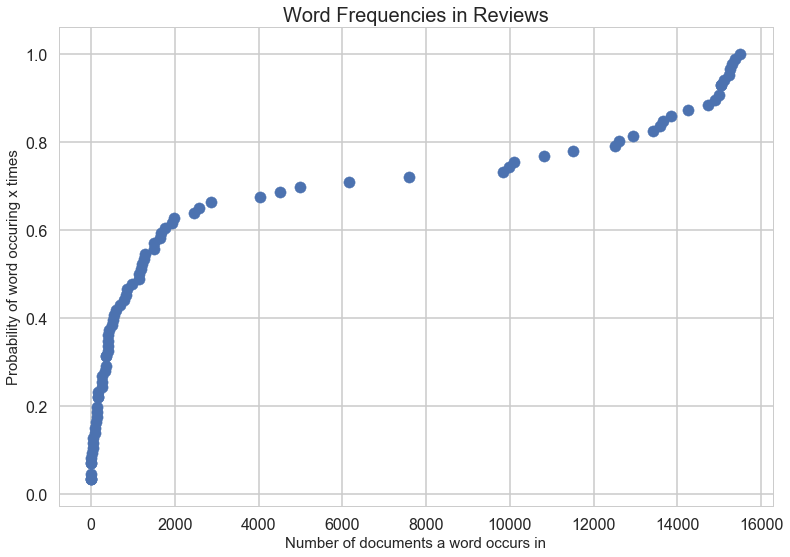

In [120]:
import matplotlib.pyplot as plt

def Cdf(t, x):
    count = 0.0
    for word, value in t.items():
        if value <= x:
            count += 1.0

    prob = count / len(occurrences)
    return prob

x_values = []
y_values = []

for word, value in occurrences.items():
    x_values.append(value)
    y_values.append(Cdf(occurrences, value))

plt.title("Word Frequencies in Reviews", fontsize = 20)
plt.ylabel("Probability of word occuring x times", fontsize = 15)
plt.xlabel("Number of documents a word occurs in", fontsize = 15)    
plt.scatter(x_values, y_values)
plt.show()

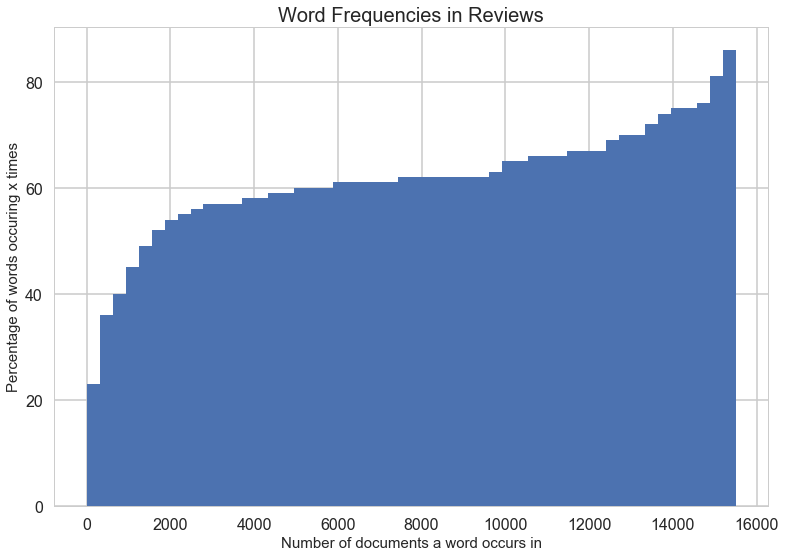

In [122]:
plt.title("Word Frequencies in Reviews", fontsize = 20)
plt.ylabel("Percentage of words occuring x times", fontsize = 15)
plt.xlabel("Number of documents a word occurs in", fontsize = 15)    
plt.hist(x_values, bins=50, cumulative=True)
plt.show()

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [53]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average


We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [58]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()


We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [59]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True


<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Answer:</b> The log likelihood allows us to measure the likelihood of a hypothesis that a review is positive or negative given that a particular word has appeared in that review. We're trying to optimise for the likelihood of the hypothesis that a given feature set (i.e. a word) is an indicator of a positive (or negative) review. If we calculate this likelihood we can then use the ratio between the likelihoods of conflicting hypotheses as a way to decide which of the two is more valid.

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Answer:</b> We would risk giving too much weight to words that appeared rarely and which hadn't been accounted for by the distribution set up by our training set. 

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

In [132]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 500 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    # your turn
    clf = MultinomialNB(alpha).fit(Xtrainthis, ytrainthis)
    result = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
    print("\n", alpha)
    print(result)
    likelihood = log_likelihood(clf, Xtrainthis, ytrainthis)
    print(likelihood)
    #print("Accuracy on training data: {:2f}".format(training_accuracy))
    #print("Accuracy on test data:     {:2f}".format(test_accuracy))
    #print("\n")


Original text is
So ingenious in concept, design and execution that you could watch it on a postage stamp-sized screen and still be engulfed by its charm.
The year's most inventive comedy.
A winning animated feature that has something for everyone on the age spectrum.
The film sports a provocative and appealing story that's every bit the equal of this technical achievement.
An entertaining computer-generated, hyperrealist animation feature (1995) that's also in effect a toy catalog.
As Lion King did before it, Toy Story revived the art of American children's animation, and ushered in a set of smart movies that entertained children and their parents. It's a landmark movie, and doesn't get old with frequent repetition.
The film will probably be more fully appreciated by adults, who'll love the snappy, knowing verbal gags, the vivid, deftly defined characters, and the overall conceptual sophistication.
Children will enjoy a new take on the irresistible idea of toys coming to life. Adults 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.



Transformed text vector is 
  (14, 0)	1
  (16, 0)	1
  (27, 0)	1
  (59, 0)	1
  (68, 0)	2
  (71, 0)	2
  (74, 0)	1
  (124, 0)	1
  (137, 0)	1
  (147, 0)	1
  (169, 0)	1
  (189, 0)	1
  (196, 0)	1
  (197, 0)	2
  (199, 0)	1
  (204, 0)	1
  (207, 0)	1
  (236, 0)	1
  (242, 0)	1
  (243, 0)	1
  (269, 0)	1
  (273, 0)	1
  (284, 0)	1
  (293, 0)	1
  (295, 0)	1
  :	:
  (15130, 54)	1
  (15161, 54)	1
  (15169, 54)	1
  (15197, 54)	1
  (15208, 54)	2
  (15216, 54)	1
  (15281, 54)	1
  (15303, 54)	1
  (15335, 54)	1
  (15346, 54)	3
  (15382, 54)	1
  (15403, 54)	1
  (15404, 54)	1
  (15439, 54)	1
  (15446, 54)	2
  (15449, 54)	3
  (15455, 54)	1
  (15473, 54)	1
  (15478, 54)	1
  (15479, 54)	3
  (15483, 54)	2
  (15486, 54)	1
  (15489, 54)	2
  (15505, 54)	1
  (15544, 54)	3

Words for each feature:
['about', 'all', 'an', 'and', 'are', 'as', 'at', 'be', 'best', 'but', 'by', 'can', 'comedy', 'director', 'even', 'film', 'for', 'from', 'good', 'has', 'have', 'he', 'his', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'li

In [127]:
print("alpha: {}".format(best_alpha))


alpha: None


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [128]:
#vectorizer = CountVectorizer(min_df=best_min_df)
vectorizer = CountVectorizer(min_df=500)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]


#clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)
clf = MultinomialNB(alpha=0.1).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Original text is
So ingenious in concept, design and execution that you could watch it on a postage stamp-sized screen and still be engulfed by its charm.
The year's most inventive comedy.
A winning animated feature that has something for everyone on the age spectrum.
The film sports a provocative and appealing story that's every bit the equal of this technical achievement.
An entertaining computer-generated, hyperrealist animation feature (1995) that's also in effect a toy catalog.
As Lion King did before it, Toy Story revived the art of American children's animation, and ushered in a set of smart movies that entertained children and their parents. It's a landmark movie, and doesn't get old with frequent repetition.
The film will probably be more fully appreciated by adults, who'll love the snappy, knowing verbal gags, the vivid, deftly defined characters, and the overall conceptual sophistication.
Children will enjoy a new take on the irresistible idea of toys coming to life. Adults 


Transformed text vector is 
  (14, 0)	1
  (16, 0)	1
  (27, 0)	1
  (59, 0)	1
  (68, 0)	2
  (71, 0)	2
  (74, 0)	1
  (124, 0)	1
  (137, 0)	1
  (147, 0)	1
  (169, 0)	1
  (189, 0)	1
  (196, 0)	1
  (197, 0)	2
  (199, 0)	1
  (204, 0)	1
  (207, 0)	1
  (236, 0)	1
  (242, 0)	1
  (243, 0)	1
  (269, 0)	1
  (273, 0)	1
  (284, 0)	1
  (293, 0)	1
  (295, 0)	1
  :	:
  (15130, 54)	1
  (15161, 54)	1
  (15169, 54)	1
  (15197, 54)	1
  (15208, 54)	2
  (15216, 54)	1
  (15281, 54)	1
  (15303, 54)	1
  (15335, 54)	1
  (15346, 54)	3
  (15382, 54)	1
  (15403, 54)	1
  (15404, 54)	1
  (15439, 54)	1
  (15446, 54)	2
  (15449, 54)	3
  (15455, 54)	1
  (15473, 54)	1
  (15478, 54)	1
  (15479, 54)	3
  (15483, 54)	2
  (15486, 54)	1
  (15489, 54)	2
  (15505, 54)	1
  (15544, 54)	3

Words for each feature:
['about', 'all', 'an', 'and', 'are', 'as', 'at', 'be', 'best', 'but', 'by', 'can', 'comedy', 'director', 'even', 'film', 'for', 'from', 'good', 'has', 'have', 'he', 'his', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'li

In [129]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[1005 3274]
 [ 887 5726]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [130]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
                best 0.84
                most 0.76
                 one 0.68
                with 0.68
                 has 0.67
                 his 0.67
                 and 0.67
                good 0.67
                film 0.66
                 its 0.66
Bad words	     P(fresh | word)
                 but 0.55
                 are 0.55
                just 0.53
                like 0.53
                have 0.53
                  so 0.53
                 can 0.52
                  or 0.50
               there 0.48
                much 0.45


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [131]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Original text is
So ingenious in concept, design and execution that you could watch it on a postage stamp-sized screen and still be engulfed by its charm.
The year's most inventive comedy.
A winning animated feature that has something for everyone on the age spectrum.
The film sports a provocative and appealing story that's every bit the equal of this technical achievement.
An entertaining computer-generated, hyperrealist animation feature (1995) that's also in effect a toy catalog.
As Lion King did before it, Toy Story revived the art of American children's animation, and ushered in a set of smart movies that entertained children and their parents. It's a landmark movie, and doesn't get old with frequent repetition.
The film will probably be more fully appreciated by adults, who'll love the snappy, knowing verbal gags, the vivid, deftly defined characters, and the overall conceptual sophistication.
Children will enjoy a new take on the irresistible idea of toys coming to life. Adults 


Transformed text vector is 
  (14, 0)	1
  (16, 0)	1
  (27, 0)	1
  (59, 0)	1
  (68, 0)	2
  (71, 0)	2
  (74, 0)	1
  (124, 0)	1
  (137, 0)	1
  (147, 0)	1
  (169, 0)	1
  (189, 0)	1
  (196, 0)	1
  (197, 0)	2
  (199, 0)	1
  (204, 0)	1
  (207, 0)	1
  (236, 0)	1
  (242, 0)	1
  (243, 0)	1
  (269, 0)	1
  (273, 0)	1
  (284, 0)	1
  (293, 0)	1
  (295, 0)	1
  :	:
  (15130, 54)	1
  (15161, 54)	1
  (15169, 54)	1
  (15197, 54)	1
  (15208, 54)	2
  (15216, 54)	1
  (15281, 54)	1
  (15303, 54)	1
  (15335, 54)	1
  (15346, 54)	3
  (15382, 54)	1
  (15403, 54)	1
  (15404, 54)	1
  (15439, 54)	1
  (15446, 54)	2
  (15449, 54)	3
  (15455, 54)	1
  (15473, 54)	1
  (15478, 54)	1
  (15479, 54)	3
  (15483, 54)	2
  (15486, 54)	1
  (15489, 54)	2
  (15505, 54)	1
  (15544, 54)	3

Words for each feature:
['about', 'all', 'an', 'and', 'are', 'as', 'at', 'be', 'best', 'but', 'by', 'can', 'comedy', 'director', 'even', 'film', 'for', 'from', 'good', 'has', 'have', 'he', 'his', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'li

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [ ]:
#your turn

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [133]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

In [134]:
Xtfidf

<15561x22125 sparse matrix of type '<class 'numpy.float64'>'
	with 156947 stored elements in Compressed Sparse Row format>

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

In [ ]:
# Your turn